# TM10007 Assignment template

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [21]:
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import percentile
from worcliver.load_data import load_data
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve, KFold
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.linear_model import LogisticRegression, Lasso 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.pipeline import Pipeline
from sklearn import svm
from scipy.stats import normaltest
from sklearn.decomposition import PCA
import statistics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier





The number of samples: 186
The number of features: 493
The number of malignant samples: 94
The number of benign samples: 92


[Text(0.5, 1.0, 'Voorbeeld grafiek om te inspecteren hoe de data is verdeeld')]

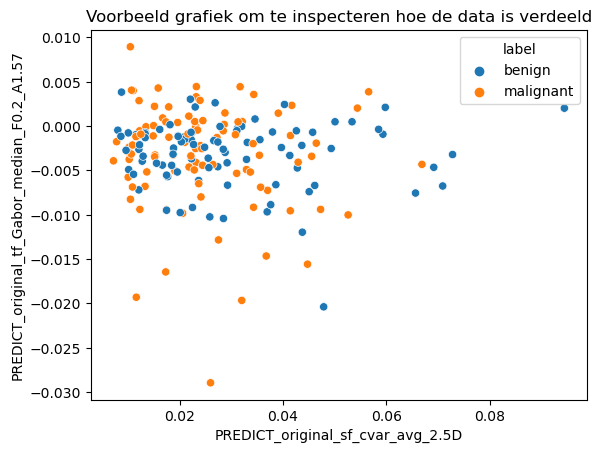

In [3]:
data = load_data()

# De label kolom even uit de dataset halen
X = data.drop('label', axis=1)   # drop the label category
y = data['label']                # Target variable die we proberen te voorspellen met het algoritme

# Make a list of feature names
feature_names = list(X.columns)

n_samples = len(data.index)
n_features = len(X.columns)
print(f'The number of samples: {n_samples}')
print(f'The number of features: {n_features}')

n_malignant = len(y[y=='malignant'])
n_benign = len(y[y=='benign'])
print(f'The number of malignant samples: {n_malignant}')
print(f"The number of benign samples: {n_benign}")

sb.scatterplot(x =feature_names[8], y = feature_names[340], data=data, hue= "label").set(title="Voorbeeld grafiek om te inspecteren hoe de data is verdeeld")

### Deleting incomplete features and patients

In [4]:
nullen = X.eq(0.0).sum()
alle_nullen = sum(nullen)
print(f'Aantal nullen in de data: {alle_nullen}') 

patient0={}
for patients in X.index:
    zero_count1 = (X.loc[patients]==0.0).sum()
    patient0[patients]=zero_count1

print(f"Hoeveelheid nullen per patient: {patient0}")

features0={}
for features in X.columns:
    zero_count2 = (X[features]==0).sum()
    features0[features]=zero_count2

features0 = {feature: count for feature, count in features0.items() if count!=0} #om alle volledige rijen, met 0 zeros eruit te halen. Vooral voor overzicht voor onszelf. 

print(f"Hoeveelheid nullen per feature: {features0}")

cutoff_feature = 0.7*n_samples
#cutoff_sample = 0.9*n_features

X_drop = X[:]
Y_drop = y[:]

for feature, counts in features0.items():
    if counts >= cutoff_feature:
        X_drop = X_drop.drop(feature, axis=1)

# for patient, count in patient0.items():
#     if count >= cutoff_sample:
#         X_drop = X_drop.drop(patient, axis=0)
#         Y_drop = Y_drop.drop(patient, axis=0)
            
print(f"Dimensies dataframe na verwijderen unrelevant features {X_drop.shape}")

#print(X_drop.head())
print(type(X_drop))



Aantal nullen in de data: 4341
Hoeveelheid nullen per patient: {'Liver-001_0': 25, 'Liver-002_0': 22, 'Liver-003_0': 22, 'Liver-004_0': 25, 'Liver-005_0': 22, 'Liver-006_0': 22, 'Liver-007_0': 25, 'Liver-008_0': 23, 'Liver-009_0': 25, 'Liver-010_0': 21, 'Liver-011_0': 25, 'Liver-012_0': 25, 'Liver-013_0': 24, 'Liver-014_0': 24, 'Liver-015_0': 23, 'Liver-016_0': 24, 'Liver-017_0': 22, 'Liver-018_0': 15, 'Liver-019_0': 22, 'Liver-020_0': 24, 'Liver-021_0': 22, 'Liver-022_0': 23, 'Liver-023_0': 25, 'Liver-024_0': 24, 'Liver-025_0': 27, 'Liver-026_0': 24, 'Liver-027_0': 24, 'Liver-028_0': 23, 'Liver-029_0': 23, 'Liver-030_0': 24, 'Liver-031_0': 24, 'Liver-032_0': 23, 'Liver-033_0': 24, 'Liver-034_0': 24, 'Liver-035_0': 23, 'Liver-036_0': 27, 'Liver-037_0': 24, 'Liver-038_0': 25, 'Liver-039_0': 24, 'Liver-040_0': 24, 'Liver-041_0': 18, 'Liver-042_0': 21, 'Liver-043_0': 26, 'Liver-044_0': 21, 'Liver-045_0': 24, 'Liver-046_0': 24, 'Liver-047_0': 25, 'Liver-048_0': 22, 'Liver-049_0': 25, 'Live

### Check normality

In [ ]:
## Normality check
# P-waarde berekenen voor elke feature (statistiek test om te testen of H0: Data is normaal verdeeld)
p_values = []
for features in X_drop.columns:
    _, p = normaltest(X[features])
    p_values.append(p)

for i, features in enumerate(X_drop.columns):
    print("Variable:", features)
    print("p-value:", p_values[i])
    if p_values[i] < 0.05:
        print("The variable is not normally distributed")
    else:
        print("The variable is normally distributed")

## Splitting data into test and trainingset

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_drop, Y_drop, test_size=0.2, random_state=42)

print("Training set dimensies:", X_train.shape, y_train.shape)
print("Testing set dimensies:", X_test.shape, y_test.shape)


VANAF HIER ALLEEN NOG MAAR DINGEN DOEN OP DE TRAININGSET!!

## Outliers


In [ ]:
#k = 1.5
n_outliers={}

#print(X_train.head)

X_train_out = X_train[:]
X_test_out = X_test[:]

for feature in X_train_out.columns:
    q25, q75 = percentile(X_train_out[feature], 25), percentile(X_train_out[feature], 75)
    iqr = q75 - q25
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    outliers = [x for x in X_train_out[feature] if x < lower or x > upper]
    n_outliers[feature] = len(outliers)

    if any(X_train_out[feature] < lower):
        X_train_out.loc[X_train_out[feature] < lower, feature] = lower
    if any(X_train_out[feature] > upper):
        X_train_out.loc[X_train_out[feature] > upper, feature] = upper    

    if any(X_test_out[feature] < lower):
        X_test_out.loc[X_test_out[feature] < lower, feature] = lower
    if any(X_test_out[feature] > upper):
        X_test_out.loc[X_test_out[feature] > upper, feature] = upper

print(n_outliers)
print(sum(n_outliers.values()))
print(max(n_outliers.values()))

#print(X_train_out.head)

            

## Scaling the data

In [ ]:
scaler = RobustScaler().fit(X_train_out) #Dit schaalt de data
X_train_normalized = scaler.transform(X_train_out)
X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns, index=X_train.index) #de normalized functie zorgt voor een numpy array, dus moet weer even teruggezet worden in een dataframe. 

X_test_normalized = scaler.transform(X_test)
X_test_normalized = pd.DataFrame(X_test_normalized, columns=X_test.columns)

# Plotten om te zien hoe het er nu uitziet: 
X_train_norm = X_train_normalized[:]     #alleen voor het plotten
X_train_norm['label'] = y_train.values    #alleen voor het plotten
sb.scatterplot(data=X_train_norm, x=feature_names[8], y=feature_names[340], hue='label').set(title="Voorbeeld grafiek om te inspecteren hoe de data is verdeeld na schalen")



## Feature selection > kan weg

In [ ]:
# # Feature selection using logistic regression
# logistic = LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=7)

# model = SelectFromModel(logistic)
# model.fit(X_train_normalized,y_train)
# #X_train_selected = model.transform(X_train_normalized)

# SF = model.get_support()
# X_train_features = X_train_normalized.loc[:,SF]

# print(X_train_features.shape)

## Dimensionality reduction > kan weg

In [ ]:
# pca=PCA(n_components=0.85)
# X_train_pca = pca.fit_transform(X_train_features)
# print(pca.n_components_)
# print(X_train_pca.shape)


## Classifier > kan weg

In [ ]:
# # KNN classifier

# k_values = [i for i in range (1,31)]
# scores = []
# for k in k_values:
#     knn = KNeighborsClassifier(n_neighbors=k)
#     score = cross_val_score(knn, X_train_pca, y_train, cv=5)
#     scores.append(np.mean(score))

# # sb.lineplot(x = k_values, y = scores, marker = 'o')
# # plt.xlabel("K Values")
# # plt.ylabel("Accuracy Score")

# # Random forest 

# n_value = 100
# random_forest = RandomForestClassifier(n_estimators=n_value)
# random_forest.fit(X_train_pca, y_train)
# #score = cross_val_score(random_forest, X_train_features, y_train, cv=5)
# print(f'Random forest score:{np.mean(score)}')

# #Linear SVC

# linear_svc = svm.SVC(kernel = 'linear', C = 1.0)
# linear_svc.fit(X_train_pca, y_train)
# #score = cross_val_score(linear_svc, X_train_features, y_train, cv=5)
# print(f'Linear SVC score: {np.mean(score)}')


## Pipeline > kan weg

In [ ]:
# # Een voorbeeld van het gebruiken van een pipeline waarbij je meerdere parameters kan testen/optimaliseren

# #hier moet C van feature selection denk ik ook nog in. 

# lr = LogisticRegression(penalty='l1', solver='liblinear')

# preprocessing = [('scaler', RobustScaler()),
#                  ('lasso', SelectFromModel(lr)),
#                  ('pca', PCA())]

# pipe_knn = Pipeline(preprocessing + [('classifier', KNeighborsClassifier())])
# pipe_rf = Pipeline(preprocessing + [('classifier', RandomForestClassifier())])
# pipe_svc = Pipeline(preprocessing + [('classifier', svm.SVC())])

# parameters_knn = {'scaler': [RobustScaler(), MinMaxScaler()], 
#                   'lasso__estimator__C': [0.5, 1, 2, 3],
#                   'pca__n_components': [0.8, 0.9, 0.95],  #we geven hm nu verschillende varianties om uit te kiezen. Idk of dat logisch is?
#                   'classifier__n_neighbors': range(5,30),
#                   'classifier__p': [1, 2],
#                   #'classifier__leaf_size': [1, 5, 10, 15]
#                  }

# parameters_rf = {'scaler': [RobustScaler(), MinMaxScaler()], 
#                  'lasso__estimator__C': [0.5, 1, 2, 3],
#                  'pca__n_components': [0.8, 0.9, 0.95],
#                  'classifier__n_estimators': [10, 50, 100, 150, 200],
#                  'classifier__max_depth': [3, 5],
#                  'classifier__min_samples_split': [5,10,15],
#                  'classifier__max_features': ['sqrt','log2', None]
#                 }

# parameters_svc = {'scaler': [RobustScaler()], 
#                   'lasso__estimator__C': [0.5, 1, 2, 3],
#                   'pca__n_components': [0.8, 0.9, 0.95],
#                   'classifier__kernel': ['linear'],
#                   'classifier__C': [0.1, 1, 10]
#                  }

# # Grid search waarbij je de optimale parameters gaat zoeken

# classifiers = {'knn': (pipe_knn, parameters_knn),
#                'Random Forest': (pipe_rf, parameters_rf),
#                'SVC': (pipe_svc, parameters_svc)}

# for name, (classifier, parameter) in classifiers.items():
#     search = RandomizedSearchCV(classifier, parameter, cv=5, n_iter=20)
#     search.fit(X_train_out, y_train)
#     print(name)
#     print("Best hyperparameters: ", search.best_params_)
#     print('validation set score: ' + str(search.best_score_))
#     #print('Training set score: ' + str(np.mean(search.cv_results_['mean_train_score'])))
#     #print('Test set score: ' + str(search.score(X_test_out, y_test)))

# print(search)


In [ ]:
## validation curve Random forest

param_range = [0.5,0.6,0.7,0.8,0.85,0.9,0.95]

pipe_rf = Pipeline([('scaler', MinMaxScaler()),
                    ('lasso', SelectFromModel(LogisticRegression(C=0.5, penalty='l1', solver='liblinear'))),
                    ('pca', PCA(n_components=0.9)),
                    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=3, max_features='sqrt',min_samples_split=20))])

train_scores, validation_scores = validation_curve(
    pipe_rf, X_train_out, y_train, param_name='pca__n_components', param_range=param_range, cv=5, n_jobs=-1, scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

plt.plot(param_range, train_mean, label='Training score')
plt.plot(param_range, validation_mean, label='Cross-validation score')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(param_range, validation_mean - validation_std, validation_mean + validation_std, alpha=0.1)
plt.title('Validation curve for number of estimators in Random Forest')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Finding hyperparameters for Lasso & PCA


In [ ]:
# Pipeline: schaling is al gebeurd, KNN staat vast (default), Lasso & PCA variëren

pipe_KNN = Pipeline([('lasso', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'))),
                    ('pca', PCA()),
                    ('classifier', KNeighborsClassifier())])

parameters = {'lasso__estimator__C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5], 
              'pca__n_components': [0.7,0.75,0.8,0.85,0.9,0.95,0.99],
              }

search_fs = RandomizedSearchCV(pipe_KNN, parameters, cv=5, n_iter=98, return_train_score=True)
search_fs.fit(X_train_normalized, y_train)
print("Best hyperparameters: ", search_fs.best_params_)
print('validation set score: ' + str(search_fs.best_score_))

best_index = search_fs.best_index_ 
train_score = search_fs.cv_results_[f"mean_train_score"][best_index]           
validation_score = search_fs.cv_results_[f"mean_test_score"][best_index]   #ging even checken of hieruit hetzelfde kwam als best_score_ en dat klopt

print("train score: ", train_score)
print("validation score: ", validation_score)


## Choosing a classifier

In [ ]:


# Feature selection

lasso_C = search_fs.best_params_['lasso__estimator__C'] 
pca_n = search_fs.best_params_['pca__n_components']

lasso_pca = [('lasso', SelectFromModel(LogisticRegression(C=lasso_C, penalty='l1', solver='liblinear'))),
             ('pca', PCA(n_components=pca_n))]

# Different classifiers

pipe_knn = Pipeline(lasso_pca + [('classifier', KNeighborsClassifier())])
pipe_rf = Pipeline(lasso_pca + [('classifier', RandomForestClassifier())])
pipe_svc = Pipeline(lasso_pca + [('classifier', svm.SVC())])

parameters_knn = {'classifier__n_neighbors': range(5,30),
                  'classifier__p': [1, 2],
                  #'classifier__leaf_size': [1, 5, 10, 15]
                 }

parameters_rf = {'classifier__n_estimators': [10, 50, 100, 150, 200],
                 'classifier__max_depth': [3, 4, 5, 6, 7],
                 'classifier__min_samples_split': [2, 4, 8, 10, 15, 20],
                 'classifier__max_features': ['sqrt','log2', None]
                }

parameters_svc = {'classifier__kernel': ['linear'],
                  'classifier__C': [0.01, 0.1, 1, 10]
                 }

classifiers = {'knn': (pipe_knn, parameters_knn),
               'Random Forest': (pipe_rf, parameters_rf),
               'SVC': (pipe_svc, parameters_svc)}

n_runs = 10
best_params_dict = {}

for name, (classifier, parameter) in classifiers.items():
     best_params_dict[name] = {"params": [], "val_scores": [], "train_scores": []}
     for i in range(n_runs):
        search = RandomizedSearchCV(classifier, parameter, cv=5, n_iter=20, return_train_score=True)
        search.fit(X_train_normalized, y_train)
        best_params_dict[name]["params"].append(search.best_params_)
        best_index = search.best_index_
        best_val_score = search.best_score_
        best_train_score = search.cv_results_[f"mean_train_score"][best_index]
        best_params_dict[name]["val_scores"].append(best_val_score)
        best_params_dict[name]["train_scores"].append(best_train_score)

means_dict = {}
for key, values in best_params_dict.items():
    val_scores = [v for v in values["val_scores"]]
    train_scores = [v for v in values["train_scores"]]
    means_dict[key] = {"mean_val_score": statistics.mean(val_scores)}
    means_dict[key]["mean_train_score"] = statistics.mean(train_scores)

print(means_dict)
print(best_params_dict)

# most_frequent_params_dict = {}
# for key, values in best_params_dict.items():
#     most_frequent_params_dict[key] = {}
#     for param_name in values[0].keys():
#         param_values = [v[param_name] for v in values if isinstance(v[param_name], (int, float))]
#         if len(param_values) > 0:
#             most_frequent_param_value = Counter(param_values).most_common(1)[0][0]
#             most_frequent_params_dict[key][param_name] = most_frequent_param_value

# print(most_frequent_params_dict)

# Full loop classifier (inner + outer loop)

In [22]:
 
#ook uitvinden hoe je hierin het splitten van de data op de 0.2/0.8 methode doet. 

lasso_C = 0.6
pca_n = 0.8

lasso_pca = [('lasso', SelectFromModel(LogisticRegression(C=lasso_C, penalty='l1', solver='liblinear'))),
             ('pca', PCA(n_components=pca_n))]

classifier_chosen = Pipeline(lasso_pca + [('classifier', svm.SVC(probability=True))])
parameters_svc = parameters_svc = {'classifier__kernel': ['linear'],
                  'classifier__C': [0.01, 0.1, 1, 10]
                 }

cv_inner = KFold(n_splits=3, shuffle=True, random_state=42)        
cv_outer = KFold(n_splits=3, shuffle=True, random_state=42)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_outliers={}
k=1.5
history = []
pointer = 1

Y_drop = np.ravel(Y_drop) #om Y_drop dezelfde type te krijgen als X_drop. anders doet de forloop het niet. 

for train_index, test_index in cv_outer.split(X_drop, Y_drop):
    x_train, x_test = X_drop.iloc[train_index], X_drop.iloc[test_index]
    y_train, y_test = Y_drop[train_index], Y_drop[test_index]
    print('\nNestedCV: {} of outer fold {}'.format(pointer, cv_outer.get_n_splits()))
    #Outliers
    X_train_out = x_train[:]
    X_test_out = x_test[:]
    for feature in X_train_out.columns:
        q25, q75 = percentile(X_train_out[feature], 25), percentile(X_train_out[feature], 75)
        iqr = q75 - q25
        cut_off = iqr * k
        lower, upper = q25 - cut_off, q75 + cut_off
        outliers = [x for x in X_train_out[feature] if x < lower or x > upper]
        n_outliers[feature] = len(outliers)

        if any(X_train_out[feature] < lower):
            X_train_out.loc[X_train_out[feature] < lower, feature] = lower
        if any(X_train_out[feature] > upper):
            X_train_out.loc[X_train_out[feature] > upper, feature] = upper    

        if any(X_test_out[feature] < lower):
            X_test_out.loc[X_test_out[feature] < lower, feature] = lower
        if any(X_test_out[feature] > upper):
            X_test_out.loc[X_test_out[feature] > upper, feature] = upper

    #Schalen
    scaler = RobustScaler().fit(X_train_out) #Dit schaalt de data
    X_train_normalized = scaler.transform(X_train_out)
    X_train_normalized = pd.DataFrame(X_train_normalized, columns=x_train.columns, index=x_train.index) #de normalized functie zorgt voor een numpy array, dus moet weer even teruggezet worden in een dataframe. 

    X_test_normalized = scaler.transform(X_test_out)
    X_test_normalized = pd.DataFrame(X_test_normalized, columns=x_test.columns)

    search_chosen = RandomizedSearchCV(classifier_chosen, parameters_svc, cv=cv_inner, n_iter=2, return_train_score=True)
    search_chosen.fit(X_train_normalized, y_train)
    pred_train = search_chosen.predict_proba(X_train_normalized)[:, 1]
    pred_test = search_chosen.predict_proba(X_test_normalized)[:, 1]
    auc_score_train = roc_auc_score(y_train, pred_train)
    auc_score_test = roc_auc_score(y_test, pred_test)
    print("""
    Best set of parameters: {}
    Best AUC              : {:.2f}

    Training
        AUC: {:.3f}
    Test
        AUC: {:.3f}
         """.format(
        search_chosen.best_params_,
        search_chosen.best_score_,
        auc_score_train,
        auc_score_test,
        )
    )
    history.append(auc_score_test)
    pointer += 1

print('Overall test performance: {:.2f}'.format(np.mean(history)))


NestedCV: 1 of outer fold 3

    Best set of parameters: {'classifier__kernel': 'linear', 'classifier__C': 1}
    Best AUC              : 0.77

    Training
        AUC: 0.992
    Test
        AUC: 0.842
         

NestedCV: 2 of outer fold 3

    Best set of parameters: {'classifier__kernel': 'linear', 'classifier__C': 0.01}
    Best AUC              : 0.70

    Training
        AUC: 0.952
    Test
        AUC: 0.838
         

NestedCV: 3 of outer fold 3

    Best set of parameters: {'classifier__kernel': 'linear', 'classifier__C': 0.01}
    Best AUC              : 0.67

    Training
        AUC: 0.977
    Test
        AUC: 0.871
         
Overall test performance: 0.85


In [7]:
#andere manier proberen, om te kijken of deze minder lang runt... maar ben bang van niet 
lasso_C = 0.6
pca_n = 0.8

lasso_pca = [('lasso', SelectFromModel(LogisticRegression(C=lasso_C, penalty='l1', solver='liblinear'))),
             ('pca', PCA(n_components=pca_n))]

classifier_chosen = Pipeline(lasso_pca + [('classifier', svm.SVC())])
parameters_svc = parameters_svc = {'classifier__kernel': ['linear'],
                  'classifier__C': [0.01, 0.1, 1, 10]
                 }

cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)        
cv_outer = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

search_chosen = RandomizedSearchCV(classifier_chosen, parameters_svc, cv=cv_inner, n_iter=4, return_train_score=True)
search_chosen.fit(X_drop, Y_drop)

nested_score = cross_val_score(search_chosen, x=X_drop, y=Y_drop, cv=cv_outer)


c:\Users\lotte\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lotte\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lotte\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lotte\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Plotjes

In [ ]:
### Learning curves:

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    pipe_knn, X_train_normalized, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
from sklearn.model_selection import validation_curve

## KNN for n_neighbors plot

param_range = [1, 3, 5, 7, 10]
train_scores, test_scores = validation_curve(
    pipe_knn, X_train_normalized, y_train, param_name='classifier__n_neighbors', param_range=param_range, cv=5, n_jobs=-1, scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, label='Training score')
plt.plot(param_range, test_mean, label='Cross-validation score')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title('Validation curve for n_neighbors in KNN')
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##


### ROC curve + AUC

In [ ]:
y_test_int = y_test.map({'malignant': 1, 'benign': 0}).astype(int)

#SVC on ROC curve
best_params_svc = best_params_dict['SVC']['params'][0]
C = best_params_svc['classifier__C']
kernel = best_params_svc['classifier__kernel']

model_svc = Pipeline(lasso_pca + [('classifier', svm.SVC(C=C, kernel=kernel, probability=True))])
model_svc.fit(X_train_normalized, y_train)

y_pred_proba_svc = model_svc.predict_proba(X_test_normalized)[:, 1]

fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test_int, y_pred_proba_svc)
auc_score_svc = roc_auc_score(y_test_int, y_pred_proba_svc)

# KNN on ROC curve
best_params_knn = best_params_dict['knn']['params'][0]
n_neighbors = best_params_knn['classifier__n_neighbors']
p = best_params_knn['classifier__p']

model_knn = Pipeline(lasso_pca + [('classifier', KNeighborsClassifier(n_neighbors=n_neighbors, p=p))])
model_knn.fit(X_train_normalized, y_train)

y_pred_proba_knn = model_knn.predict_proba(X_test_normalized)[:, 1]

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test_int, y_pred_proba_knn)
auc_score_knn = roc_auc_score(y_test_int, y_pred_proba_knn)

# RF on ROC curve
best_params_rf = best_params_dict['Random Forest']['params'][0]
n_estimators = best_params_rf['classifier__n_estimators']
max_depth = best_params_rf['classifier__max_depth']
min_samples_split = best_params_rf['classifier__min_samples_split']
max_features = best_params_rf['classifier__max_features']

model_rf = Pipeline(lasso_pca + [('classifier', RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, max_features=max_features))])
model_rf.fit(X_train_normalized, y_train)

y_pred_proba_rf = model_rf.predict_proba(X_test_normalized)[:, 1]

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_int, y_pred_proba_rf)
auc_score_rf = roc_auc_score(y_test_int, y_pred_proba_rf)

plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'KNN (AUC = {auc_score_knn:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {auc_score_rf:.2f})')
plt.plot(fpr_svc, tpr_svc, color='red', lw=2, label=f'SVC (AUC = {auc_score_svc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()
